In [ ]:
# from google.colab import files
# files.upload()
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle einops
!kaggle datasets download -d tekbahadurkshetri/landslide4sense -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other


In [ ]:
!unzip -q landslide4sense.zip -d data
!rm -r /content/landslide4sense.zip

In [ ]:
!wget -q https://raw.githubusercontent.com/NX-AI/vision-lstm/main/vision_lstm/vision_lstm_util.py "/content/vision_lstm_util.py"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from glob import glob
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import math
import time

from vision_lstm import VisionLSTM

In [ ]:
# f_data = np.zeros((1, 128,128, 3))
# with h5py.File("/content/data/TrainData/img/image_1.h5") as hdf:
#     data = np.array(hdf.get('img'))
#     plt.imshow(data[:, :, 3:0:-1])

#     data_red = data[:, :, 3]
#     data_green = data[:, :, 2]
#     data_blue = data[:, :, 1]
#     data_nir = data[:, :, 7]
#     data_rgb = data[:, :, 3:0:-1]
#     data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
#     f_data[0, :, :, 0] = data_ndvi
#     f_data[0, :, :, 1] = data[:, :, 12]
#     f_data[0, :, :, 2] = data[:, :, 13]

#     print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
#     plt.imshow(data_ndvi)

In [ ]:
def get_data(data_path):
    d=np.zeros((len(data_path), 1, 128, 128))
    for i, path in enumerate(data_path):
            with h5py.File(path, 'r') as hdf:
                key=list(hdf.keys())[0]
                data = np.array(hdf.get(key))
                if key=='mask':
                    data=data.reshape(128,128,1)
                # print(data[:, :, 0].shape)
                # temp=np.transpose(data[:, :, 0], (2, 0, 1))
                temp=data[:, :, 0]
                d[i, 0, :, :] = temp
    return d

In [ ]:
TRAIN_PATH = r"/content/data/TrainData/img/*.h5"
TRAIN_MASK = r"/content/data/TrainData/mask/*.h5"
VAL_PATH = r"/content/data/ValidData/img/*.h5"
TEST_PATH = r"/content/data/TestData/img/*.h5"
all_train = sorted(glob(TRAIN_PATH))
all_mask = sorted(glob(TRAIN_MASK))
all_val = sorted(glob(VAL_PATH))
all_test = sorted(glob(TEST_PATH))

In [ ]:
train_data=get_data(all_train)
mask_data=get_data(all_mask)
val_data=get_data(all_val)
test_data=get_data(all_test)
print(train_data.shape, mask_data.shape, val_data.shape, test_data.shape)

(3799, 1, 128, 128) (3799, 1, 128, 128) (245, 1, 128, 128) (800, 1, 128, 128)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [ ]:
def load_data(train_data, mask_data):
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    transform=None
    dataset = CustomDataset(train_data, mask_data, transform=transform)
    return DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
class UNet_wrong(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contraction path
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv9 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # Vlm
        # self.vlm = model=VisionLSTM(
        #     dim=256,
        #     depth=24,
        #     patch_size=1,
        #     input_shape=(256,64),
        #     output_shape=None,
        #     drop_path_rate=0.05,
        #     stride=None,  # set to 8 for long-sequence fine-tuning,
        #     mode=None,
        #     pooling=None,
        # )
        # Expansive path
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.conv19 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Contraction path
        c1 = F.relu(self.conv1(x))
        c1 = F.relu(self.conv2(c1))
        p1 = self.pool1(c1)

        c2 = F.relu(self.conv3(p1))
        c2 = F.relu(self.conv4(c2))
        p2 = self.pool2(c2)

        c3 = F.relu(self.conv5(p2))
        c3 = F.relu(self.conv6(c3))
        p3 = self.pool3(c3)

        c4 = F.relu(self.conv7(p3))
        c4 = F.relu(self.conv8(c4))
        p4 = self.pool4(c4)

        c5 = F.relu(self.conv9(p4))
        c5 = F.relu(self.conv10(c5))
        # vlm
        # print("c5", c5.shape)
        # c5=c5.reshape(c5.shape[0], c5.shape[1], -1)
        # c5 = self.vlm(c5)
        # Expansive path
        u6 = self.upconv1(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = F.relu(self.conv11(u6))
        c6 = F.relu(self.conv12(c6))

        u7 = self.upconv2(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = F.relu(self.conv13(u7))
        c7 = F.relu(self.conv14(c7))

        u8 = self.upconv3(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = F.relu(self.conv15(u8))
        c8 = F.relu(self.conv16(c8))

        u9 = self.upconv4(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = F.relu(self.conv17(u9))
        c9 = F.relu(self.conv18(c9))

        outputs = torch.sigmoid(self.conv19(c9))

        return outputs

# model = UNet(in_channels=1, out_channels=1)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels, 16)
        self.encoder2 = self.conv_block(16, 32)
        self.encoder3 = self.conv_block(32, 64)
        self.encoder4 = self.conv_block(64, 128)

        self.bottleneck = self.conv_block(128, 256)

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.downsample(enc1))
        enc3 = self.encoder3(self.downsample(enc2))
        enc4 = self.encoder4(self.downsample(enc3))

        bottleneck = self.bottleneck(self.downsample(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = nn.ReLU(inplace=True)(dec4)  # Add ReLU after upconv4 output
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = nn.ReLU(inplace=True)(dec3)  # Add ReLU after upconv3 output
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = nn.ReLU(inplace=True)(dec2)  # Add ReLU after upconv2 output
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = nn.ReLU(inplace=True)(dec1)  # Add ReLU after upconv1 output
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

model = UNet(in_channels=1, out_channels=1)

In [ ]:
class UNet_VLM(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet_VLM, self).__init__()

        self.encoder1 = self.conv_block(in_channels, 16)
        self.encoder2 = self.conv_block(16, 32)
        self.encoder3 = self.conv_block(32, 64)
        self.encoder4 = self.conv_block(64, 128)

        self.vlm = VisionLSTM(
            dim=256,
            depth=24,
            patch_size=16,
            input_shape=(1, 1, 1),
            output_shape=None,
            drop_path_rate=0.05,
            stride=None,
            mode=None,
            pooling=None,
        )

        self.bottleneck = self.conv_block(128, 256)

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.downsample(enc1))
        enc3 = self.encoder3(self.downsample(enc2))
        enc4 = self.encoder4(self.downsample(enc3)) # [B, 128, 16, 16]

        enc4=enc4.reshape(enc4.shape[0], enc4.shape[1], -1)
        enc4=self.vlm(enc4)
        n = int(math.sqrt(enc4.shape[2]))
        enc4=enc4.reshape(enc4.shape[0], enc4.shape[1], n, n)
        # print(enc4.shape)
        bottleneck = self.bottleneck(self.downsample(enc4))
        # print(bottleneck.shape)

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

model = UNet(in_channels=1, out_channels=1)

In [ ]:
# model = UNet(in_channels=1, out_channels=1)
# def remove_prefix(state_dict, prefix):
#     return {key[len(prefix):]: value for key, value in state_dict.items() if key.startswith(prefix)}
# model_path="/content/best_model_with_val.pth"
# # model_path="/content/best_model_unet_100epochs.pth"
# state_dict = torch.load(model_path, map_location="cpu")
# if list(state_dict.keys())[0].startswith("_orig_mod."):
#     state_dict = remove_prefix(state_dict, "_orig_mod.")
# model.load_state_dict(state_dict)

In [ ]:
model(torch.randn(1,1,128,128)).shape

torch.Size([1, 1, 128, 128])

In [ ]:
sum(p.numel() for p in model.parameters())

1943761

In [ ]:
import os;os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")
# print(f"CUDA version: {torch.version.cuda}")

In [ ]:
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
model = UNet(in_channels=1, out_channels=1).to(device)
model=torch.compile(model)
loss_fn = nn.BCELoss()
# loss_fn = dice_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loader = load_data(train_data, mask_data)
# valid_loader = load_data(val_data, val_mask_data)
valid_loader = train_loader
val_needed = False

In [ ]:
train_loss_history = []
val_loss_history = []
train_precision_history = []
val_precision_history = []
train_recall_history = []
val_recall_history = []
train_f1_history = []
val_f1_history = []

In [ ]:
# torch._dynamo.config.suppress_errors = True

In [ ]:
import os
os.environ['TORCH_LOGS'] = '+dynamo'
os.environ['TORCHDYNAMO_VERBOSE'] = '1'

In [ ]:
num_epochs = 100
highest_f1=0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_f1=0
    train_precision=0
    train_recall=0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)
        # if torch.isnan(images).any() or torch.isnan(masks).any():
        #     raise ValueError("Input contains NaNs!")
        # if torch.isinf(images).any() or torch.isinf(masks).any():
        #     raise ValueError("Input contains Infs!")
        optimizer.zero_grad()
        outputs = model(images)
        if outputs.shape != masks.shape:
            raise ValueError(f"Output shape {outputs.shape} does not match target shape {masks.shape}")
        loss = loss_fn(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        masks=masks.cpu().numpy().flatten()
        preds=preds.cpu().numpy().flatten()
        train_f1 += f1_score(masks, preds)
        train_precision += precision_score(masks, preds, zero_division=1)
        train_recall += recall_score(masks, preds, zero_division=1)
    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)

    val_loss = train_loss
    val_f1 = train_f1
    val_precision = train_precision
    val_recall = train_recall
    if val_needed:
        model.eval()

        val_loss = 0
        val_f1 = 0
        val_precision = 0
        val_recall = 0

        with torch.no_grad():
            for images, masks in valid_loader:
                images = images.float().to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = outputs > 0.5
                masks=masks.cpu().numpy().flatten()
                preds=preds.cpu().numpy().flatten()
                val_f1 += f1_score(masks, preds)
                val_precision += precision_score(masks, preds, zero_division=1)
                val_recall += recall_score(masks, preds, zero_division=1)
            val_loss /= len(valid_loader)
            val_f1 /= len(valid_loader)
            val_precision /= len(valid_loader)
            val_recall /= len(valid_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_precision_history.append(train_precision)
    val_precision_history.append(val_precision)
    train_recall_history.append(train_recall)
    val_recall_history.append(val_recall)
    train_f1_history.append(train_f1)
    val_f1_history.append(val_f1)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f},Train F1: {train_f1:.4f},Train Precision: {train_precision:.4f},Train Recall: {train_recall:.4f}')
    if val_needed:
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}')

    if val_f1 > highest_f1:
        highest_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        torch.save(model.state_dict(), "/content/drive/MyDrive/temp/best_model.pth")
        print(f"Saved the model to best_model.pth with validation f1 of {val_f1}")
    torch.save(model.state_dict(), "latest_model.pth")
    torch.save(model.state_dict(), "/content/drive/MyDrive/temp/latest_model.pth")
print("Training complete")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


BackendCompilerFailed: backend='inductor' raised:
AssertionError: 

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

# Plot training & validation loss values
ax11.plot(train_loss_history)
ax11.plot(val_loss_history)
ax11.title.set_text('UNet Model Loss')
ax11.set_ylabel('Loss')
ax11.set_xlabel('Epoch')
ax11.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation precision values
ax12.plot(train_precision_history)
ax12.plot(val_precision_history)
ax12.set_title('UNet Model Precision')
ax12.set_ylabel('Precision')
ax12.set_xlabel('Epoch')
ax12.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation recall values
ax13.plot(train_recall_history)
ax13.plot(val_recall_history)
ax13.set_title('UNet Model Recall')
ax13.set_ylabel('Recall')
ax13.set_xlabel('Epoch')
ax13.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation F1 values
ax14.plot(train_f1_history)
ax14.plot(val_f1_history)
ax14.set_title('UNet Model F1 Score')
ax14.set_ylabel('F1 Score')
ax14.set_xlabel('Epoch')
ax14.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

In [ ]:
model = UNet(in_channels=1, out_channels=1)
def remove_prefix(state_dict, prefix):
    return {key[len(prefix):]: value for key, value in state_dict.items() if key.startswith(prefix)}
model_path="best_model_with_val.pth"
# model_path="best_model.pth"
# model_path="/content/best_model_unet_100epochs.pth"
state_dict = torch.load(model_path, map_location="cpu")
if list(state_dict.keys())[0].startswith("_orig_mod."):
    state_dict = remove_prefix(state_dict, "_orig_mod.")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model = UNet_VLM(in_channels=1, out_channels=1)
model_path="/content/best_model_vlm.pth"
# model_path="/content/latest_model_vlm(more_epochs)overfit.pth"
# model_path="/content/latest_model_vlm.pth"
state_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(state_dict)

<All keys matched successfully>

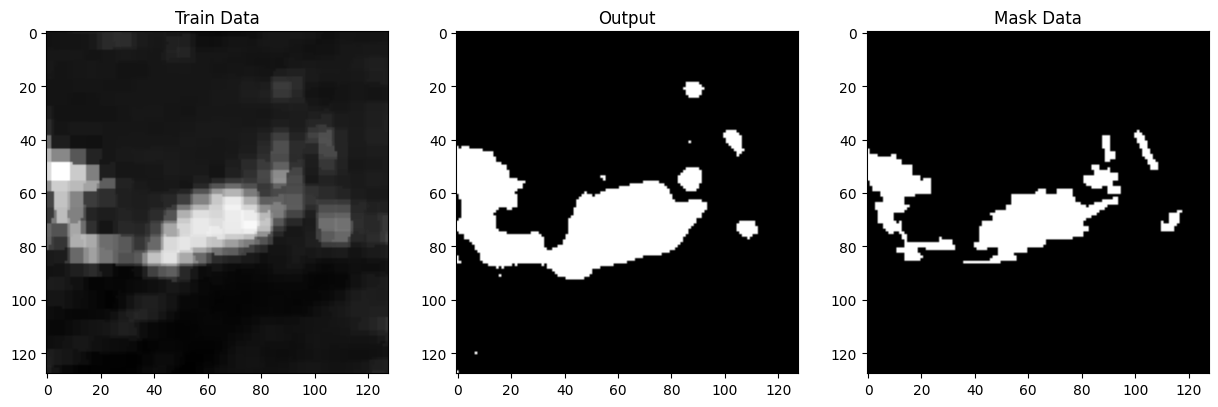

In [ ]:
i=12
device='cpu'
inp=train_data[i]
inp=torch.tensor(inp.reshape(1, 1, 128, 128))
inp=inp.float().to(device)
output=model(inp)

train_data_squeezed = np.squeeze(inp.cpu().numpy())
mask_data_squeezed = np.squeeze(mask_data[i])
output_squeezed = np.squeeze(output.cpu().detach().numpy())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(train_data_squeezed, cmap='gray')
axes[0].set_title('Train Data')

axes[2].imshow(mask_data_squeezed, cmap='gray')
axes[2].set_title('Mask Data')

axes[1].imshow(output_squeezed>0.1, cmap='gray')
axes[1].set_title('Output')

plt.show()